In [29]:
from devito import Grid, Function,TimeFunction, Eq, Operator, configuration, Eq, solve
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
# Parameters
nx = 200
ny = 200
nt  = int(1e+4)
xmin = 0.
ymin = 0.
xmax = 1.
ymax = 1.
extent = (xmin, xmax, ymin, ymax)

# Increase the space order for higher accuracy
space_order = 4

# Silence the runtime performance logging
configuration['log-level'] = 'ERROR'

# Create the grid
grid = Grid(shape=(nx, ny), extent=(xmax, ymax))
x, y = grid.dimensions
t = grid.stepping_dim

In [42]:
# Now with Devito we will turn `p` into `TimeFunction` object 
# to make all the buffer switching implicit
p = TimeFunction(name='p', grid=grid, space_order=space_order)
p.data[:] = 0.

In [43]:
# Initialise the source term `b`
b = Function(name='b', grid=grid)
b.data[:] = 0.

x_vals = np.linspace(xmin, xmax, nx)
y_vals = np.linspace(ymin, ymax, ny)
X, Y = np.meshgrid(x_vals, y_vals) 
b.data[:] = - 32 * ((1 - Y) * Y + (1 - X) * X)

In [44]:
# Create Laplace equation base on `p`
eq = Eq(p.laplace, b)
# Let SymPy solve for the central stencil point
stencil = solve(eq, p)
# Let our stencil populate the buffer `p.forward`
eq_stencil = Eq(p.forward, stencil)

In [45]:
eq_stencil

Eq(p(t + dt, x, y), -0.533333333*(0.75*h_x**2*h_y**2*b(x, y) + 0.0625*h_x**2*p(t, x, y - 2*h_y) - 1.0*h_x**2*p(t, x, y - h_y) - 1.0*h_x**2*p(t, x, y + h_y) + 0.0625*h_x**2*p(t, x, y + 2*h_y) + 0.0625*h_y**2*p(t, x - 2*h_x, y) - 1.0*h_y**2*p(t, x - h_x, y) - 1.0*h_y**2*p(t, x + h_x, y) + 0.0625*h_y**2*p(t, x + 2*h_x, y))/(h_x**2 + h_y**2))

In [46]:
# Create the boundary condition
bc = [Eq(p[t + 1, x, 0], 0.)]
bc += [Eq(p[t + 1, x, ny-1], 0.)]
bc += [Eq(p[t + 1, 0, y], 0.)]
bc += [Eq(p[t + 1, nx-1, y], 0.)]

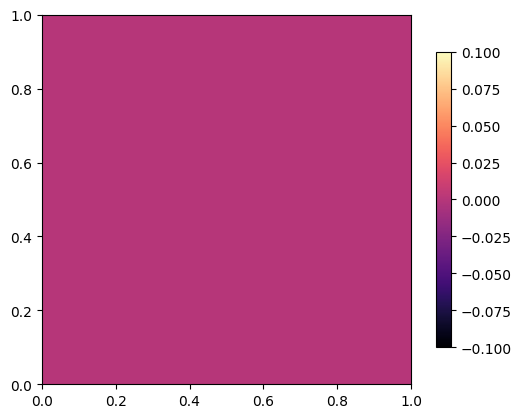

In [47]:
plt.imshow(p.data[0], cmap='magma', extent=extent)
plt.colorbar(shrink=0.8)

In [48]:
#NBVAL_IGNORE_OUTPUT
configuration['log-level'] = 'ERROR'
# Create and execute the operator for a number of timesteps
op = Operator([eq_stencil] + bc)
%time op(time=nt)

CPU times: user 8.4 s, sys: 0 ns, total: 8.4 s
Wall time: 8.61 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=8.312491000058312, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=0.03342600000001262, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

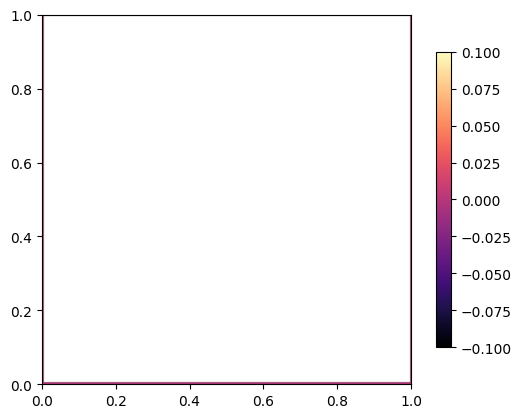

In [38]:
plt.imshow(p.data[0], cmap='magma', extent=extent)
plt.colorbar(shrink=0.8)

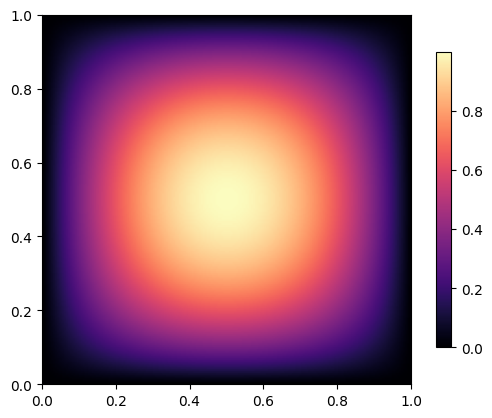

In [39]:
u_exact = 16*(1 - X) * X * (1 - Y) * Y


plt.imshow(u_exact, cmap='magma', extent=extent)
plt.colorbar(shrink=0.8)
plt.show()

In [40]:
# Calculate the error
error = np.abs(p.data[0] - u_exact)
print(f'Maximum error: {np.max(error)}')

Maximum error: nan
